In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os
import nltk
import datetime

from gensim.models.fasttext import FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 불러오기

raw_train = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/train.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/test_x.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/sample_submission.csv')

In [102]:
train = raw_train.copy()
test = raw_test.copy()

In [103]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = ['the', 'a', 'to', 'of', 'in', 'an', 'as', 'at', 'as', 'with', 'above', 'on', 'or', 'over', 'by', 'to', 'and']
# stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
#              "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
#              "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
#              "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
#              "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
#              "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
#              "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
#              "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
#              "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
#              "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
#              "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [104]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [105]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values.reshape(-1, 1)
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879, 1)


In [ ]:
count_by_author = []

for idx in range(5):
    df = train[train['author']==idx]['text'].values
    temp_tokenizer = Tokenizer()

    temp_tokenizer.fit_on_texts(df)
    temp_dict = temp_tokenizer.word_counts
    temp_dict = sorted(temp_dict.items(), key=lambda x : x[1], reverse=True)
    print('작가 {}의 유니크한 단어수 {}' .format(idx, len(temp_dict)))
    count_by_author.append(dict(temp_dict))

작가 0의 유니크한 단어수 20602
작가 1의 유니크한 단어수 15410
작가 2의 유니크한 단어수 21014
작가 3의 유니크한 단어수 19186
작가 4의 유니크한 단어수 17799


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1080x1440 with 0 Axes>

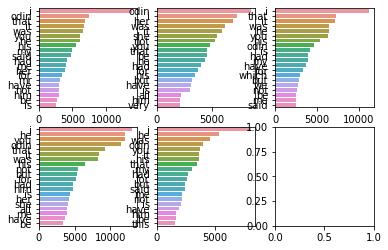

In [ ]:

plt.figure(figsize=(15, 20))

fig, axes = plt.subplots(2, 3)

sns.barplot(y=list(count_by_author[0].keys())[:20], x=list(count_by_author[0].values())[:20], ax=axes[0, 0])
sns.barplot(y=list(count_by_author[1].keys())[:20], x=list(count_by_author[1].values())[:20], ax=axes[0, 1])
sns.barplot(y=list(count_by_author[2].keys())[:20], x=list(count_by_author[2].values())[:20], ax=axes[0, 2])
sns.barplot(y=list(count_by_author[3].keys())[:20], x=list(count_by_author[3].values())[:20], ax=axes[1, 0])
sns.barplot(y=list(count_by_author[4].keys())[:20], x=list(count_by_author[4].values())[:20], ax=axes[1, 1])

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]), <a list of 9 Text major ticklabel objects>)

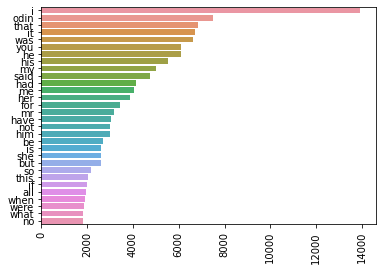

In [ ]:
sns.barplot(y=list(count_by_author[0].keys())[:30], x=list(count_by_author[0].values())[:30])
plt.xticks(rotation=90)

In [106]:
max_length = 500
padding_type='post'
vocab_size= 15000

In [107]:
tokenizer = Tokenizer(oov_token='oov', num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
x_test = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(x_train.shape, x_test.shape)

(54879, 500) (19617, 500)


## 1. FastText 사용하기

In [10]:
!pip install fasttext

     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3044379 sha256=73a4d2c5f1f5e7efe8d7069fca2a2f787ffefa329cffd39931f7c925fe9e9196
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [51]:
import fasttext
import fasttext.util

In [12]:
print(f"== LOAD fasttext START at {datetime.datetime.now()}")
ft = fasttext.load_model('/content/drive/MyDrive/FastText/cc.en.300.bin')
print(f"== LOAD fasttext   END at {datetime.datetime.now()}")

== LOAD fasttext START at 2020-12-01 04:27:13.732028
== LOAD fasttext   END at 2020-12-01 04:29:17.353338


In [108]:
embedding_dim = 300
embedding_matrix = np.zeros( (len(word_index)+1, embedding_dim) )

In [109]:
# 임베딩테이블 만들기
for word, idx in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None :
        embedding_matrix[idx] = embedding_vector

In [110]:
# 임베딩 테이블
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.21967494e-02,  1.47352798e-03, -3.66373621e-02, ...,
         3.82993668e-02, -6.97156740e-03,  3.46689485e-02],
       [-5.17441928e-02,  7.39639550e-02, -1.30568799e-02, ...,
         2.37025172e-01,  4.47519124e-04, -4.19306662e-03],
       ...,
       [-1.14901196e-02,  1.77695379e-02, -7.17559550e-03, ...,
         1.88565888e-02, -2.11709607e-02, -1.53971398e-02],
       [-1.79175157e-02,  1.67236254e-02, -7.29322061e-03, ...,
         1.72605272e-04,  1.51997712e-03, -2.69044321e-02],
       [-4.95688394e-02,  2.36806385e-02,  1.32462056e-02, ...,
        -1.53529341e-03,  6.91159070e-03,  3.62609886e-02]])

In [111]:
target_col = 'author'
n_class = 5
seed = 42

In [112]:
import tensorflow.keras.backend as K
# Mish 활성화 함수
def mish(x):
    return x * K.tanh(K.softplus(x))

In [70]:
vocab_size

15000

In [119]:
def get_model() :

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Flatten, MaxPool1D, GlobalAveragePooling1D, Flatten

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix[0:vocab_size]], input_length=max_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 3, padding='same', activation=mish, strides=1))
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation=mish))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.002))

    return model

## 2. Hold Out

In [19]:
from sklearn.model_selection import train_test_split

In [80]:
X_train_holdout, X_test_holdout, y_train_holdout, y_test_holdout = train_test_split(x_train, y, test_size=0.2, random_state=123)

In [90]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

In [120]:
model = get_model()
history = model.fit(X_train_holdout, y_train_holdout, 
                    epochs           = 20,
                    callbacks        = [es],
                    batch_size       = 16,
                    validation_data = (X_test_holdout, y_test_holdout))

Epoch 1/20
2744/2744 [==============================] - 128s 47ms/step - loss: 1.0911 - val_loss: 0.8011
Epoch 2/20
2744/2744 [==============================] - 126s 46ms/step - loss: 0.6924 - val_loss: 0.6799
Epoch 3/20
2744/2744 [==============================] - 126s 46ms/step - loss: 0.5490 - val_loss: 0.6709
Epoch 4/20
2744/2744 [==============================] - 125s 46ms/step - loss: 0.4727 - val_loss: 0.6687
Epoch 5/20
2744/2744 [==============================] - 126s 46ms/step - loss: 0.4201 - val_loss: 0.7022
Epoch 6/20
2744/2744 [==============================] - 127s 46ms/step - loss: 0.3767 - val_loss: 0.7630
Epoch 00006: early stopping


## 3. K-Fold

In [121]:

# 5-Fold 시행
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
validation_pred = np.zeros((y.shape[0], n_class))
test_pred = np.zeros((test.shape[0], n_class))

i = 0
for train_idx, val_idx in tqdm_notebook(cv.split(x_train, y)):
    print("{}-Fold" .format(i+1))
    X_train = x_train[train_idx]
    y_train = y[train_idx]

    X_validation = x_train[val_idx]
    y_validation = y[val_idx]

    CNN = get_model()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    CNN.fit(X_train, y_train,
             epochs           = 20,
             callbacks        = [es],
             batch_size       = 16,
             validation_data  = (X_validation, y_validation))
    
    validation_pred[val_idx, :] = CNN.predict(X_validation)
    test_pred += (CNN.predict(x_test) / 5)
    print('')

    i += 1

1-Fold
Epoch 1/20
2744/2744 [==============================] - 123s 45ms/step - loss: 1.0625 - val_loss: 0.7935
Epoch 2/20
2744/2744 [==============================] - 121s 44ms/step - loss: 0.6962 - val_loss: 0.6872
Epoch 3/20
2744/2744 [==============================] - 120s 44ms/step - loss: 0.5587 - val_loss: 0.6656
Epoch 4/20
2744/2744 [==============================] - 119s 43ms/step - loss: 0.4838 - val_loss: 0.6728
Epoch 5/20
2744/2744 [==============================] - 117s 42ms/step - loss: 0.4351 - val_loss: 0.6904
Epoch 00005: early stopping

2-Fold
Epoch 1/20
2744/2744 [==============================] - 126s 46ms/step - loss: 1.0634 - val_loss: 0.7657
Epoch 2/20
2744/2744 [==============================] - 126s 46ms/step - loss: 0.6552 - val_loss: 0.6676
Epoch 3/20
2744/2744 [==============================] - 124s 45ms/step - loss: 0.5337 - val_loss: 0.6539
Epoch 4/20
2744/2744 [==============================] - 123s 45ms/step - loss: 0.4646 - val_loss: 0.6845
Epoch 5/20
2

In [ ]:
CNN.summary()

NameError: ignored

In [ ]:
from sklearn.metrics import log_loss, recall_score, confusion_matrix

In [ ]:
y_pred = np.argmax(validation_pred, axis=1)
y_real = y.reshape((1, -1))[0]

In [ ]:
confusion_matrix(y_pred, y_real)

array([[ 9907,   705,   838,   744,   906],
       [  526,  4997,   307,   354,   149],
       [ 1014,   710,  8542,  1087,   877],
       [ 1058,   625,  1211, 12562,   573],
       [  730,   185,   656,   316,  5300]])

In [ ]:
# log_loss

log_loss(pd.get_dummies(y_real), validation_pred)

0.6685693883318483

In [ ]:
# 결과 저장
sample_submission[['0','1','2','3','4']] = test_pred
sample_submission.to_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/02_나의코드/01_딥러닝/Test예측결과/submission_12.csv', index = False, encoding = 'utf-8')